In [4]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
 
from torch.utils.tensorboard import SummaryWriter


In [6]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x


In [ ]:
epochs = 500
batch_size = 12
image_size = 64
device = "cpu"
args.lr = 3e-4

In [ ]:
def train():
    setup_logging(args.run_name)
    device = args.device
    dataloader = get_data(args)
    model = UNet().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=args.image_size, device=device)
    logger = SummaryWriter(os.path.join("runs", args.run_name))
    l = len(dataloader)

    for epoch in range(args.epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, (images, _) in enumerate(pbar):
            images = images.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(MSE=loss.item())
            logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

        sampled_images = diffusion.sample(model, n=images.shape[0])
        save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
        torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))




Using device: cpu
Input dimension: 11

Starting training...


Epoch 1/50: 100%|███████████████████| 79/79 [00:01<00:00, 64.21it/s, loss=0.332]
09:23:17 - INFO: Epoch 1/50, Average Loss: 0.5432
Epoch 2/50: 100%|████████████████████| 79/79 [00:01<00:00, 67.16it/s, loss=1.05]
09:23:19 - INFO: Epoch 2/50, Average Loss: 0.4091
Epoch 3/50: 100%|███████████████████| 79/79 [00:01<00:00, 65.71it/s, loss=0.293]
09:23:20 - INFO: Epoch 3/50, Average Loss: 0.3877
Epoch 4/50: 100%|███████████████████| 79/79 [00:01<00:00, 63.85it/s, loss=0.613]
09:23:21 - INFO: Epoch 4/50, Average Loss: 0.3766
Epoch 5/50: 100%|███████████████████| 79/79 [00:01<00:00, 62.61it/s, loss=0.333]
09:23:22 - INFO: Epoch 5/50, Average Loss: 0.3653
Epoch 6/50: 100%|███████████████████| 79/79 [00:01<00:00, 66.83it/s, loss=0.438]
09:23:24 - INFO: Epoch 6/50, Average Loss: 0.3736
Epoch 7/50: 100%|███████████████████| 79/79 [00:01<00:00, 64.92it/s, loss=0.252]
09:23:25 - INFO: Epoch 7/50, Average Loss: 0.3605
Epoch 8/50: 100%|███████████████████| 79/79 [00:01<00:00, 67.10it/s, loss=0.286]
09

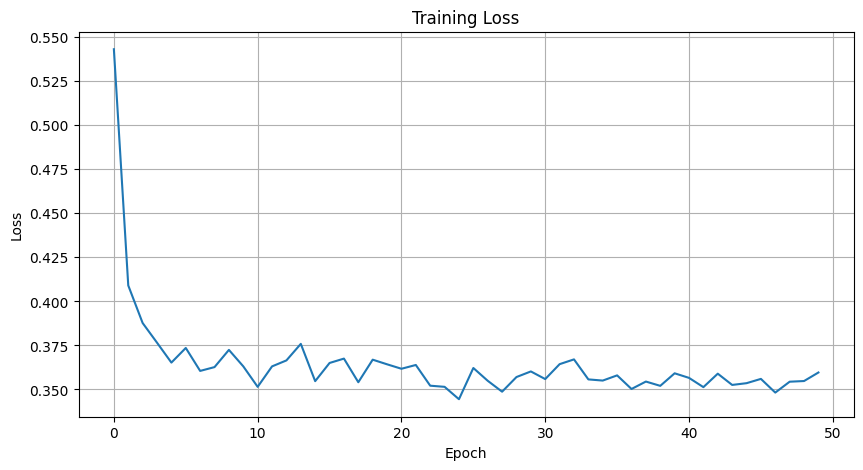

09:24:17 - INFO: Sampling 1000 new data points...



Generating samples...


499it [00:05, 91.20it/s]
09:24:22 - INFO: Sampling 1000 new data points...
499it [00:10, 46.81it/s]



Visualizing results...
Unconditional generation:


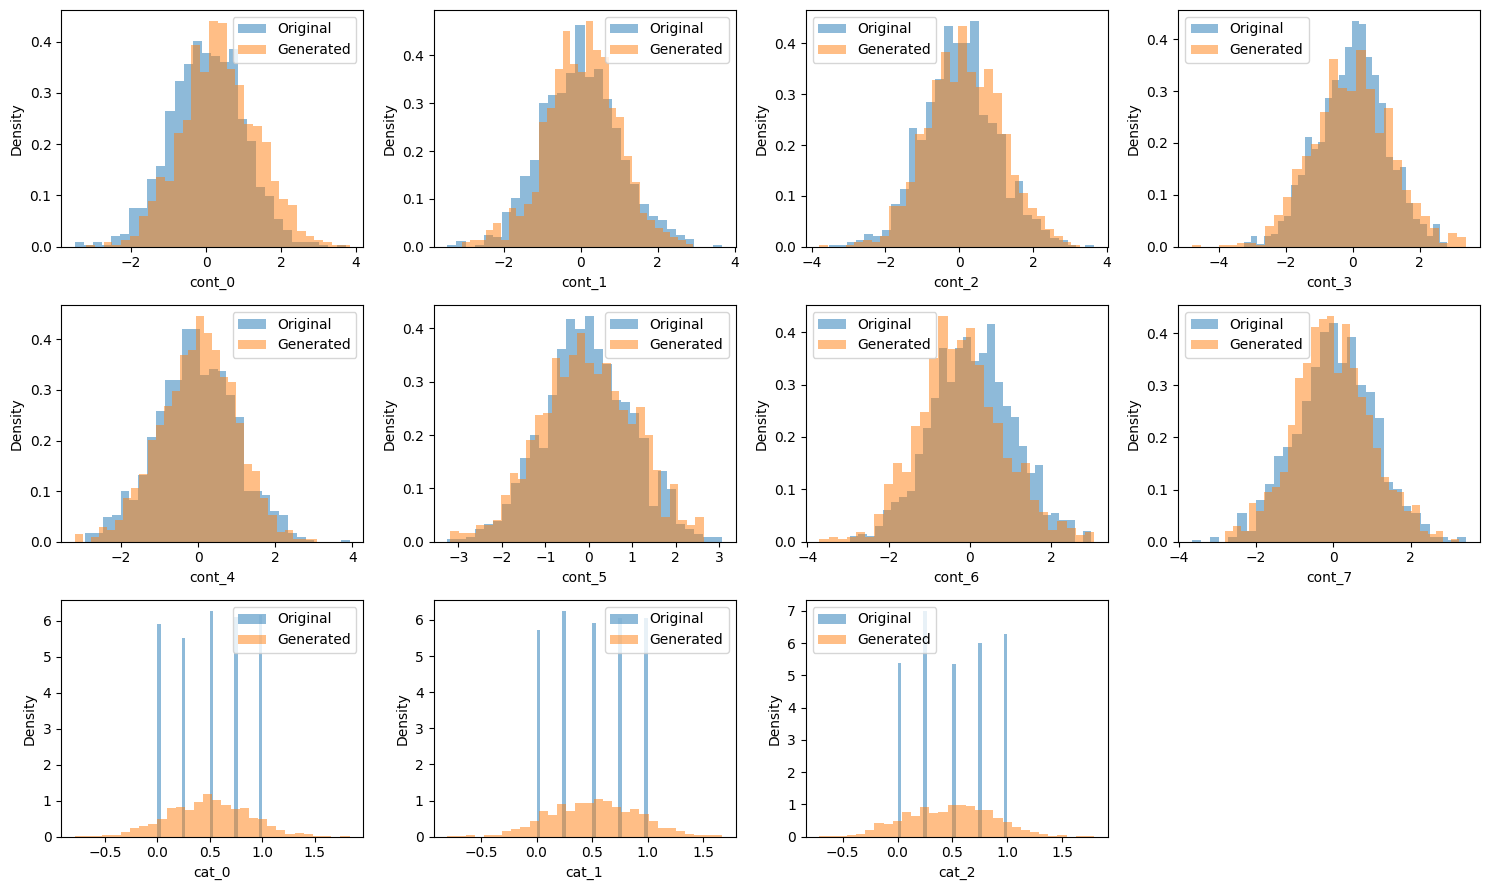

Conditional generation (Class 0):


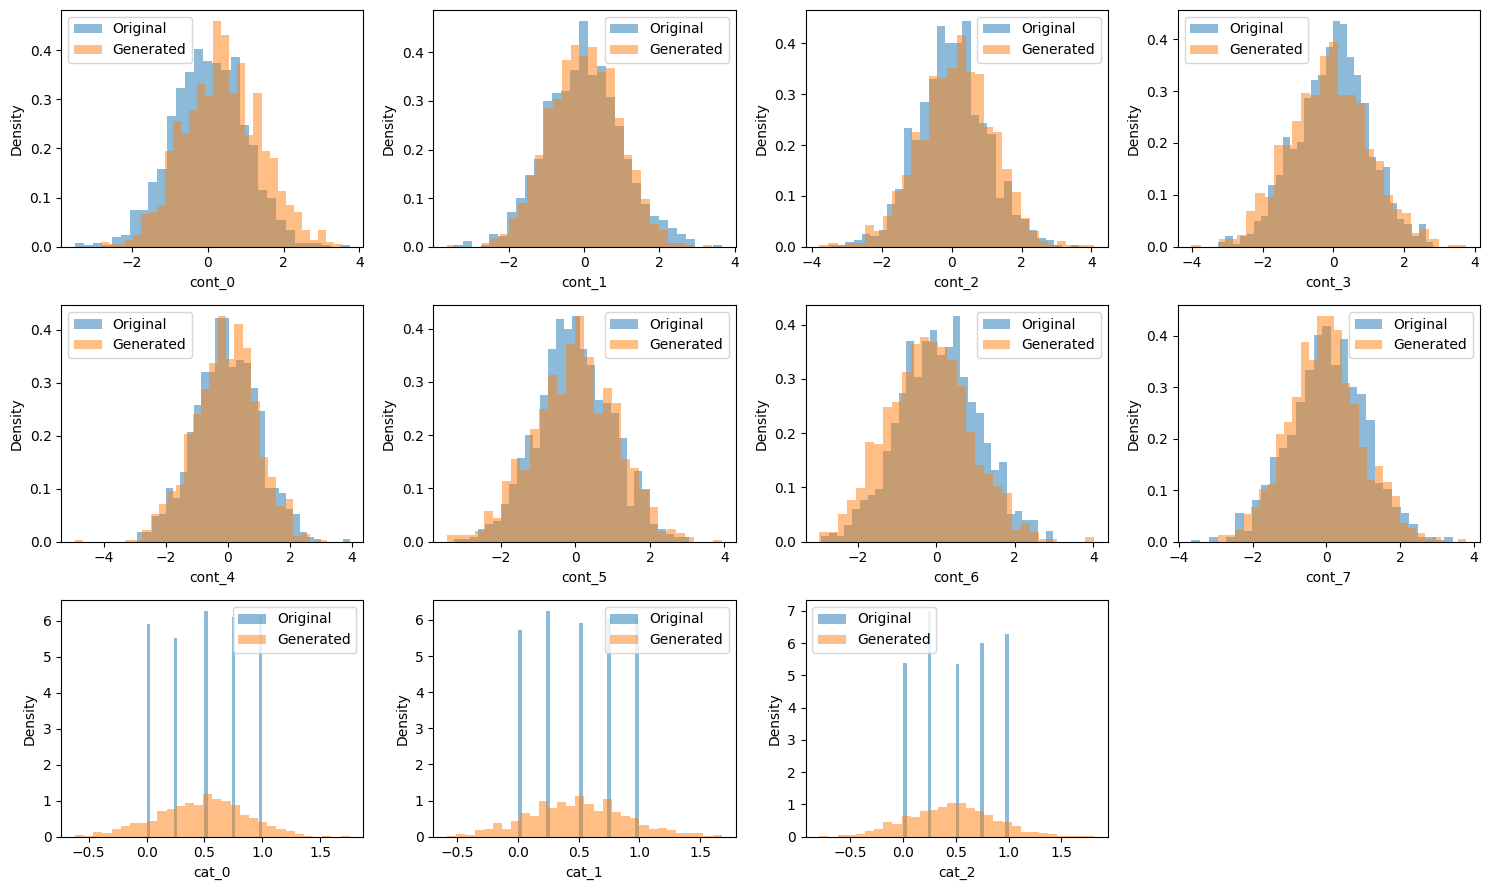


Model saved as 'tabular_diffusion_model.pt'

=== Generation Statistics ===
Original data - Mean: 0.1402, Std: 0.9098
Generated data - Mean: 0.1555, Std: 0.9321
Conditional data - Mean: 0.1328, Std: 0.9497


In [2]:
"""
Tabular Diffusion Model Implementation
Adapted from https://github.com/dome272/Diffusion-Models-pytorch for tabular data
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
from typing import Optional, Tuple, List
import logging

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


# ==================== Model Architecture ====================

class SinusoidalPositionEmbeddings(nn.Module):
    """Sinusoidal position embeddings for timesteps"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class TabularBlock(nn.Module):
    """Basic building block for tabular data processing"""
    def __init__(self, in_dim, out_dim, time_emb_dim, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim)
        self.norm1 = nn.LayerNorm(out_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(out_dim, out_dim)
        self.norm2 = nn.LayerNorm(out_dim)
        
        # Time embedding projection
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, out_dim),
            nn.GELU()
        )
        
        # Residual connection
        if in_dim != out_dim:
            self.residual_proj = nn.Linear(in_dim, out_dim)
        else:
            self.residual_proj = nn.Identity()
    
    def forward(self, x, t):
        residual = self.residual_proj(x)
        
        x = self.linear1(x)
        x = self.norm1(x)
        x = self.act(x)
        x = self.dropout(x)
        
        # Add time embedding
        time_emb = self.time_mlp(t)
        x = x + time_emb
        
        x = self.linear2(x)
        x = self.norm2(x)
        x = self.act(x)
        x = self.dropout(x)
        
        return x + residual


class TabularDiffusionModel(nn.Module):
    """Neural network for tabular data diffusion"""
    def __init__(
        self,
        input_dim,
        hidden_dims=[256, 512, 1024, 512, 256],
        time_emb_dim=128,
        num_classes=None,  # For conditional generation
        dropout=0.1
    ):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_emb_dim = time_emb_dim
        self.num_classes = num_classes
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.GELU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim),
        )
        
        # Class embedding for conditional generation
        if num_classes is not None:
            self.class_emb = nn.Embedding(num_classes, time_emb_dim)
        
        # Initial projection
        self.input_proj = nn.Linear(input_dim, hidden_dims[0])
        
        # Main blocks
        self.blocks = nn.ModuleList()
        prev_dim = hidden_dims[0]
        for hidden_dim in hidden_dims:
            self.blocks.append(TabularBlock(prev_dim, hidden_dim, time_emb_dim, dropout))
            prev_dim = hidden_dim
        
        # Output projection
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dims[-1], hidden_dims[-1] // 2),
            nn.GELU(),
            nn.Linear(hidden_dims[-1] // 2, input_dim)
        )
    
    def forward(self, x, t, y=None):
        # Time embedding
        t_emb = self.time_mlp(t)
        
        # Add class embedding if conditional
        if y is not None and self.num_classes is not None:
            t_emb = t_emb + self.class_emb(y)
        
        # Process through network
        x = self.input_proj(x)
        
        for block in self.blocks:
            x = block(x, t_emb)
        
        x = self.output_proj(x)
        return x


# ==================== Diffusion Process ====================

class TabularDiffusion:
    """Diffusion process for tabular data"""
    def __init__(
        self,
        noise_steps=1000,
        beta_start=1e-4,
        beta_end=0.02,
        device="cuda"
    ):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device
        
        # Prepare noise schedule
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
    
    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def noise_data(self, x, t):
        """Add noise to data at timestep t"""
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon
    
    def sample_timesteps(self, n):
        """Sample random timesteps"""
        return torch.randint(low=1, high=self.noise_steps, size=(n,))
    
    def sample(self, model, n, input_dim, y=None, cfg_scale=3):
        """Generate samples from the model"""
        logging.info(f"Sampling {n} new data points...")
        model.eval()
        with torch.no_grad():
            # Start from random noise
            x = torch.randn((n, input_dim)).to(self.device)
            
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                
                # Predict noise
                if y is not None:
                    # Classifier-free guidance
                    predicted_noise = model(x, t, y)
                    if cfg_scale > 0:
                        uncond_predicted_noise = model(x, t, None)
                        predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                else:
                    predicted_noise = model(x, t)
                
                # Denoise
                alpha = self.alpha[t][:, None]
                alpha_hat = self.alpha_hat[t][:, None]
                beta = self.beta[t][:, None]
                
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * predicted_noise) + torch.sqrt(beta) * noise
        
        model.train()
        return x


# ==================== Dataset ====================

def collate_fn(batch):
    """Custom collate function for DataLoader"""
    if isinstance(batch[0], tuple):
        # If dataset returns (x, y) tuples
        data = torch.stack([item[0] for item in batch])
        labels = torch.stack([item[1] for item in batch])
        return data, labels
    else:
        # If dataset returns only x
        return torch.stack(batch)


class TabularDataset(Dataset):
    """Dataset class for tabular data"""
    def __init__(self, data, labels=None, categorical_cols=None, continuous_cols=None):
        self.data = data
        self.labels = labels
        self.categorical_cols = categorical_cols or []
        self.continuous_cols = continuous_cols or []
        
        # Preprocess data
        self.preprocessed_data = self._preprocess(data)
    
    def _preprocess(self, data):
        """Preprocess tabular data"""
        if isinstance(data, pd.DataFrame):
            processed = []
            
            # Process continuous columns
            if self.continuous_cols:
                cont_data = data[self.continuous_cols].values
                scaler = StandardScaler()
                cont_data = scaler.fit_transform(cont_data)
                processed.append(cont_data)
                self.cont_scaler = scaler
            
            # Process categorical columns
            if self.categorical_cols:
                cat_data = []
                self.label_encoders = {}
                for col in self.categorical_cols:
                    le = LabelEncoder()
                    encoded = le.fit_transform(data[col])
                    cat_data.append(encoded.reshape(-1, 1))
                    self.label_encoders[col] = le
                
                if cat_data:
                    cat_data = np.concatenate(cat_data, axis=1)
                    # Normalize categorical to [0, 1]
                    cat_data = cat_data / cat_data.max(axis=0)
                    processed.append(cat_data)
            
            # Concatenate all features
            if processed:
                return np.concatenate(processed, axis=1).astype(np.float32)
            else:
                return data.values.astype(np.float32)
        else:
            # Assume numpy array
            return data.astype(np.float32)
    
    def __len__(self):
        return len(self.preprocessed_data)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.preprocessed_data[idx], dtype=torch.float32)
        if self.labels is not None:
            y = torch.tensor(self.labels[idx], dtype=torch.long)
            return x, y
        return x


# ==================== Training ====================

def train_tabular_diffusion(
    model,
    train_loader,
    diffusion,
    epochs=100,
    lr=1e-4,
    device="cuda"
):
    """Train the tabular diffusion model"""
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_losses = []
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for batch in pbar:
            # Handle different batch formats
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                data, labels = batch
                data = data.to(device)
                labels = labels.to(device)
            elif isinstance(batch, torch.Tensor):
                data = batch.to(device)
                labels = None
            else:
                # If batch is a list with single element
                data = batch[0] if isinstance(batch, list) else batch
                data = data.to(device)
                labels = None
            
            # Sample timesteps
            t = diffusion.sample_timesteps(data.shape[0]).to(device)
            
            # Add noise
            x_t, noise = diffusion.noise_data(data, t)
            
            # Predict noise
            if labels is not None and model.num_classes is not None:
                # Randomly drop labels for classifier-free guidance
                if np.random.random() < 0.1:
                    labels = None
            
            predicted_noise = model(x_t, t, labels)
            
            # Calculate loss
            loss = mse(noise, predicted_noise)
            
            # Backprop
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            
            # Track loss
            epoch_losses.append(loss.item())
            pbar.set_postfix(loss=loss.item())
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        logging.info(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")
    
    return losses


# ==================== Example Usage ====================

def generate_synthetic_data(n_samples=10000, n_features=10, n_classes=3):
    """Generate synthetic tabular data for testing"""
    # Generate continuous features
    continuous_data = np.random.randn(n_samples, n_features)
    
    # Generate categorical features
    categorical_data = np.random.randint(0, 5, size=(n_samples, 3))
    
    # Generate labels
    labels = np.random.randint(0, n_classes, size=n_samples)
    
    # Combine into DataFrame
    df = pd.DataFrame(continuous_data, columns=[f'cont_{i}' for i in range(n_features)])
    for i in range(3):
        df[f'cat_{i}'] = categorical_data[:, i]
    
    return df, labels


def visualize_samples(original_data, generated_data, feature_names=None):
    """Visualize original vs generated data distributions"""
    n_features = original_data.shape[1]
    n_cols = min(4, n_features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]
    
    for i in range(n_features):
        if i < len(axes):
            ax = axes[i]
            ax.hist(original_data[:, i], bins=30, alpha=0.5, label='Original', density=True)
            ax.hist(generated_data[:, i], bins=30, alpha=0.5, label='Generated', density=True)
            ax.set_xlabel(feature_names[i] if feature_names else f'Feature {i}')
            ax.set_ylabel('Density')
            ax.legend()
    
    # Hide unused subplots
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()


# ==================== Main ====================

if __name__ == "__main__":
    # Set device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Generate synthetic data
    df, labels = generate_synthetic_data(n_samples=5000, n_features=8, n_classes=3)
    
    # Define columns
    continuous_cols = [col for col in df.columns if 'cont_' in col]
    categorical_cols = [col for col in df.columns if 'cat_' in col]
    
    # Create dataset
    dataset = TabularDataset(
        df, 
        labels=labels,
        continuous_cols=continuous_cols,
        categorical_cols=categorical_cols
    )
    
    # Create dataloader
    train_loader = DataLoader(
        dataset, 
        batch_size=64, 
        shuffle=True,
        collate_fn=collate_fn
    )
    
    # Get input dimension
    input_dim = dataset.preprocessed_data.shape[1]
    print(f"Input dimension: {input_dim}")
    
    # Initialize model
    model = TabularDiffusionModel(
        input_dim=input_dim,
        hidden_dims=[128, 256, 512, 256, 128],
        time_emb_dim=64,
        num_classes=3,  # For conditional generation
        dropout=0.1
    ).to(device)
    
    # Initialize diffusion
    diffusion = TabularDiffusion(
        noise_steps=500,
        beta_start=1e-4,
        beta_end=0.02,
        device=device
    )
    
    # Train model
    print("\nStarting training...")
    losses = train_tabular_diffusion(
        model=model,
        train_loader=train_loader,
        diffusion=diffusion,
        epochs=50,
        lr=1e-3,
        device=device
    )
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.show()
    
    # Generate samples
    print("\nGenerating samples...")
    n_samples = 1000
    
    # Unconditional generation
    generated_samples = diffusion.sample(
        model=model,
        n=n_samples,
        input_dim=input_dim
    ).cpu().numpy()
    
    # Conditional generation (generate samples for class 0)
    conditional_labels = torch.zeros(n_samples, dtype=torch.long).to(device)
    conditional_samples = diffusion.sample(
        model=model,
        n=n_samples,
        input_dim=input_dim,
        y=conditional_labels,
        cfg_scale=2
    ).cpu().numpy()
    
    # Visualize results
    print("\nVisualizing results...")
    original_samples = dataset.preprocessed_data[:n_samples]
    
    print("Unconditional generation:")
    visualize_samples(original_samples, generated_samples, feature_names=df.columns.tolist())
    
    print("Conditional generation (Class 0):")
    visualize_samples(original_samples, conditional_samples, feature_names=df.columns.tolist())
    
    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'input_dim': input_dim,
        'model_config': {
            'hidden_dims': [128, 256, 512, 256, 128],
            'time_emb_dim': 64,
            'num_classes': 3,
            'dropout': 0.1
        }
    }, 'tabular_diffusion_model.pt')
    
    print("\nModel saved as 'tabular_diffusion_model.pt'")
    
    # Print statistics
    print("\n=== Generation Statistics ===")
    print(f"Original data - Mean: {original_samples.mean():.4f}, Std: {original_samples.std():.4f}")
    print(f"Generated data - Mean: {generated_samples.mean():.4f}, Std: {generated_samples.std():.4f}")
    print(f"Conditional data - Mean: {conditional_samples.mean():.4f}, Std: {conditional_samples.std():.4f}")

In [20]:
import pandas as pd 

In [21]:
import sys 
sys.path.append('../')

In [22]:
from fmds.utils.io.read import RawDataReader

In [23]:
from fmds.utils.io.read import RawDataReader

In [24]:
import  fmds.config as cfg 
from fmds.settings import Settings

In [25]:
rdr = RawDataReader(raw_data_directory=Settings.backfill.paths.RAW_DATA_PATH)

In [26]:
equity_data = rdr.read_30_equities()

In [27]:
equity_data=equity_data[['tradeDate', 'ClosePrice', 'Ticker']].dropna().reset_index(drop=True)

In [28]:
equity_data['tradeDate'] = pd.to_datetime(equity_data['tradeDate'], errors='coerce').dt.date
equity_data['ClosePrice'] = pd.to_numeric(equity_data['ClosePrice'], errors='coerce')


In [29]:
equity_data.dropna(inplace = True) 

In [30]:
equity_data.sort_values(by ='tradeDate', ascending = True, inplace = True)

In [31]:
equity_data['prior_1D_return'] = equity_data['ClosePrice']/ equity_data.groupby('Ticker')['ClosePrice'].shift(1)-1

In [32]:
equity_data['tradeDate'] = pd.to_datetime(equity_data['tradeDate'] ).dt.date

In [33]:
data = equity_data.pivot_table(index= 'tradeDate', 
                               columns = 'Ticker',
                               values = 'prior_1D_return').dropna(axis=1, 
                                                 how='all').dropna(axis=0,
                                                                   how='all').fillna(0)

In [34]:
data =  np.array(data) 

In [35]:
data.shape

(1365, 32)

In [36]:
data

array([[ 0.00796826, -0.00433387,  0.00294507, ..., -0.00215232,
        -0.00203579,  0.00767809],
       [-0.00470314, -0.0052394 ,  0.01060706, ..., -0.01111664,
        -0.00926646, -0.008184  ],
       [ 0.01608633,  0.01725954, -0.01752253, ...,  0.00184564,
        -0.00343085, -0.01508038],
       ...,
       [ 0.01639835,  0.02199622,  0.00851593, ...,  0.01154734,
        -0.00500204,  0.0239615 ],
       [-0.01211259, -0.00300856,  0.03183112, ..., -0.00342466,
        -0.00020519,  0.00671334],
       [ 0.00605609, -0.00676482, -0.00818353, ...,  0.01099656,
        -0.00133402,  0.0214347 ]])

09:59:13 - INFO: Dataset created with shape: (1365, 32)


Using device: cpu
Input dimension: 32
Total parameters: 1,320,608

Starting training...


Epoch 1: 100%|█████████████| 35/35 [00:00<00:00, 72.41it/s, loss=1.12, lr=0.001]
09:59:14 - INFO: Epoch 1/50 - Train Loss: 1.1346 - Val Loss: 1.0198
09:59:14 - INFO: Checkpoint saved: best_model.pt
Epoch 2: 100%|█████████| 35/35 [00:00<00:00, 71.95it/s, loss=0.724, lr=0.000999]
09:59:15 - INFO: Epoch 2/50 - Train Loss: 0.9923 - Val Loss: 0.9906
09:59:15 - INFO: Checkpoint saved: best_model.pt
Epoch 3: 100%|██████████| 35/35 [00:00<00:00, 71.80it/s, loss=1.13, lr=0.000998]
09:59:15 - INFO: Epoch 3/50 - Train Loss: 1.0015 - Val Loss: 1.0036
Epoch 4: 100%|█████████| 35/35 [00:00<00:00, 71.21it/s, loss=0.849, lr=0.000996]
09:59:16 - INFO: Epoch 4/50 - Train Loss: 0.9900 - Val Loss: 1.4140
Epoch 5: 100%|█████████| 35/35 [00:00<00:00, 72.11it/s, loss=0.832, lr=0.000994]
09:59:16 - INFO: Epoch 5/50 - Train Loss: 1.0151 - Val Loss: 1.0035
Epoch 6: 100%|██████████| 35/35 [00:00<00:00, 72.89it/s, loss=1.11, lr=0.000991]
09:59:17 - INFO: Epoch 6/50 - Train Loss: 1.0106 - Val Loss: 0.9908
Epoch 7:


Generating samples...


499it [00:01, 355.83it/s]
09:59:41 - INFO: Sampling 100 new data points...
09:59:41 - INFO: Using DDIM sampling with 50 steps...
49it [00:00, 360.30it/s]



Visualizing results...


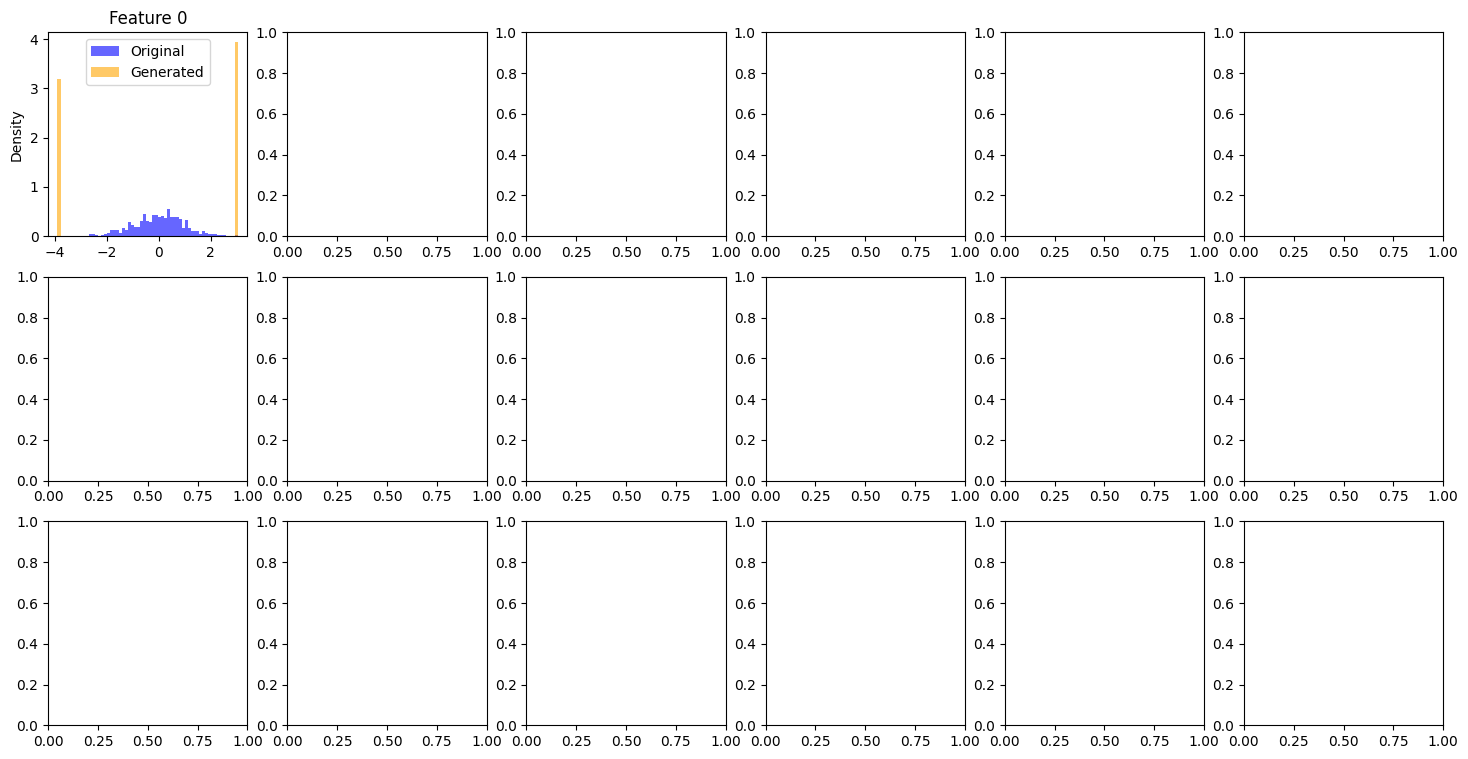

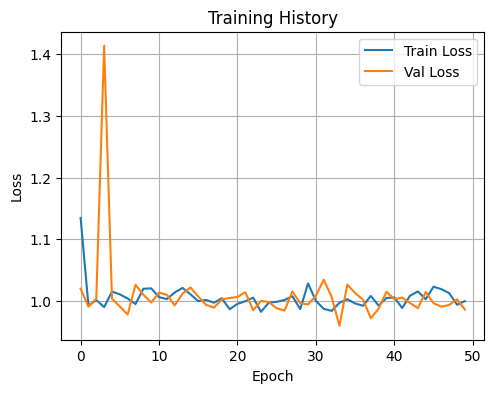

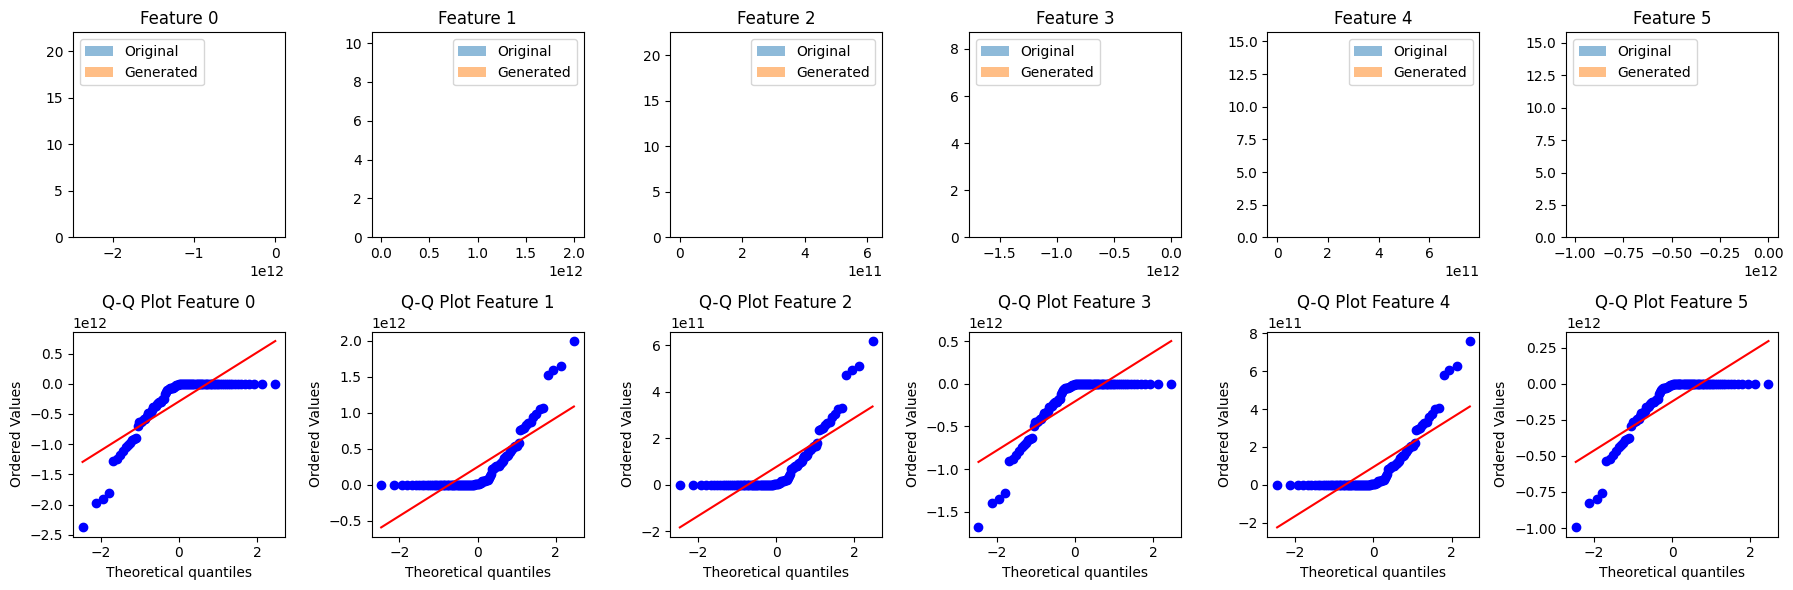


=== Generation Quality Metrics ===
mean_diff: 162114240512.0000
std_diff: 270555348992.0000
corr_diff: 0.9722
mean_ks_stat: 0.8491

Generated data saved to 'generated_data.csv'

Done!


In [33]:
"""
Tabular Diffusion Model for Unlabeled Data
Adapted for real-world tabular datasets (e.g., financial data, time series)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
import pandas as pd
from typing import Optional, Union, List
import logging
import warnings
warnings.filterwarnings('ignore')

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


# ==================== Model Architecture ====================

class SinusoidalPositionEmbeddings(nn.Module):
    """Sinusoidal position embeddings for timesteps"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class ResidualBlock(nn.Module):
    """Residual block with time embedding"""
    def __init__(self, in_dim, out_dim, time_emb_dim, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim)
        self.norm1 = nn.LayerNorm(out_dim)
        self.act = nn.SiLU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(out_dim, out_dim)
        self.norm2 = nn.LayerNorm(out_dim)
        
        # Time embedding projection
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_dim * 2)
        )
        
        # Residual connection
        if in_dim != out_dim:
            self.residual_proj = nn.Linear(in_dim, out_dim)
        else:
            self.residual_proj = nn.Identity()
    
    def forward(self, x, t):
        residual = self.residual_proj(x)
        
        # First layer
        x = self.linear1(x)
        x = self.norm1(x)
        
        # Add time embedding
        time_emb = self.time_mlp(t)
        scale, shift = time_emb.chunk(2, dim=-1)
        x = x * (1 + scale) + shift
        
        x = self.act(x)
        x = self.dropout(x)
        
        # Second layer
        x = self.linear2(x)
        x = self.norm2(x)
        x = self.act(x)
        x = self.dropout(x)
        
        return x + residual


class TabularDiffusionModel(nn.Module):
    """Neural network for tabular data diffusion (unconditional)"""
    def __init__(
        self,
        input_dim,
        hidden_dims=[256, 512, 1024, 512, 256],
        time_emb_dim=128,
        dropout=0.1,
        use_attention=False
    ):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_emb_dim = time_emb_dim
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim),
        )
        
        # Initial projection
        self.input_proj = nn.Linear(input_dim, hidden_dims[0])
        
        # Residual blocks
        self.blocks = nn.ModuleList()
        prev_dim = hidden_dims[0]
        for i, hidden_dim in enumerate(hidden_dims):
            self.blocks.append(ResidualBlock(prev_dim, hidden_dim, time_emb_dim, dropout))
            prev_dim = hidden_dim
        
        # Optional attention layer
        if use_attention:
            self.attention = nn.MultiheadAttention(hidden_dims[-1], num_heads=8, batch_first=True)
            self.attention_norm = nn.LayerNorm(hidden_dims[-1])
        else:
            self.attention = None
        
        # Output projection
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dims[-1], hidden_dims[-1] // 2),
            nn.SiLU(),
            nn.Linear(hidden_dims[-1] // 2, input_dim)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_mlp(t)
        
        # Process through network
        x = self.input_proj(x)
        
        for block in self.blocks:
            x = block(x, t_emb)
        
        # Optional attention
        if self.attention is not None:
            x_att = self.attention_norm(x)
            x_att = x_att.unsqueeze(1)  # Add sequence dimension
            x_att, _ = self.attention(x_att, x_att, x_att)
            x = x + x_att.squeeze(1)
        
        x = self.output_proj(x)
        return x


# ==================== Diffusion Process ====================

class TabularDiffusion:
    """Diffusion process for tabular data"""
    def __init__(
        self,
        noise_steps=1000,
        beta_start=1e-4,
        beta_end=0.02,
        schedule_type="linear",
        device="cuda"
    ):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device
        
        # Prepare noise schedule
        self.beta = self.prepare_noise_schedule(schedule_type).to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
    
    def prepare_noise_schedule(self, schedule_type="linear"):
        if schedule_type == "linear":
            return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
        elif schedule_type == "cosine":
            # Cosine schedule
            steps = self.noise_steps + 1
            x = torch.linspace(0, self.noise_steps, steps)
            alphas_cumprod = torch.cos(((x / self.noise_steps) + 0.008) / (1 + 0.008) * torch.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
            return torch.clip(betas, 0.0001, 0.9999)
        else:
            raise ValueError(f"Unknown schedule type: {schedule_type}")
    
    def noise_data(self, x, t):
        """Add noise to data at timestep t"""
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon
    
    def sample_timesteps(self, n):
        """Sample random timesteps"""
        return torch.randint(low=1, high=self.noise_steps, size=(n,))
    
    @torch.no_grad()
    def sample(self, model, n, input_dim, sampling_steps=None):
        """Generate samples from the model using DDPM or DDIM sampling"""
        logging.info(f"Sampling {n} new data points...")
        model.eval()
        
        # Use DDIM sampling if sampling_steps is specified
        if sampling_steps is not None and sampling_steps < self.noise_steps:
            return self.ddim_sample(model, n, input_dim, sampling_steps)
        
        # Standard DDPM sampling
        x = torch.randn((n, input_dim)).to(self.device)
        
        for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
            t = (torch.ones(n) * i).long().to(self.device)
            predicted_noise = model(x, t)
            
            alpha = self.alpha[t][:, None]
            alpha_hat = self.alpha_hat[t][:, None]
            beta = self.beta[t][:, None]
            
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * predicted_noise) + torch.sqrt(beta) * noise
        
        model.train()
        return x
    
    @torch.no_grad()
    def ddim_sample(self, model, n, input_dim, sampling_steps):
        """DDIM sampling for faster generation"""
        logging.info(f"Using DDIM sampling with {sampling_steps} steps...")
        model.eval()
        
        # Create subset of timesteps
        c = self.noise_steps // sampling_steps
        timesteps = np.asarray(list(range(0, self.noise_steps, c)))
        
        x = torch.randn((n, input_dim)).to(self.device)
        
        for i in tqdm(reversed(range(len(timesteps) - 1)), position=0):
            t = torch.full((n,), timesteps[i + 1], device=self.device, dtype=torch.long)
            prev_t = torch.full((n,), timesteps[i], device=self.device, dtype=torch.long)
            
            alpha_t = self.alpha_hat[t][:, None]
            alpha_prev = self.alpha_hat[prev_t][:, None]
            
            predicted_noise = model(x, t)
            
            # DDIM update rule
            pred_x0 = (x - torch.sqrt(1 - alpha_t) * predicted_noise) / torch.sqrt(alpha_t)
            dir_xt = torch.sqrt(1 - alpha_prev) * predicted_noise
            x = torch.sqrt(alpha_prev) * pred_x0 + dir_xt
        
        model.train()
        return x


# ==================== Dataset ====================

class TabularDataset(Dataset):
    """Dataset class for tabular data"""
    def __init__(
        self, 
        data: Union[pd.DataFrame, np.ndarray, torch.Tensor],
        scaler_type: str = "standard",
        handle_nan: str = "mean"
    ):
        """
        Args:
            data: Input data (DataFrame, numpy array, or tensor)
            scaler_type: Type of scaler ('standard', 'robust', 'minmax', or 'none')
            handle_nan: How to handle NaN values ('mean', 'median', 'drop', or 'zero')
        """
        self.handle_nan = handle_nan
        self.scaler_type = scaler_type
        self.scaler = None
        
        # Convert to numpy if needed
        if isinstance(data, pd.DataFrame):
            self.column_names = data.columns.tolist()
            data = data.values
        elif isinstance(data, torch.Tensor):
            data = data.numpy()
        else:
            self.column_names = [f"feature_{i}" for i in range(data.shape[1])]
        
        # Handle NaN values
        data = self._handle_nan(data)
        
        # Scale data
        self.data = self._scale_data(data)
        
        logging.info(f"Dataset created with shape: {self.data.shape}")
    
    def _handle_nan(self, data):
        """Handle NaN values in the data"""
        if self.handle_nan == "mean":
            col_mean = np.nanmean(data, axis=0)
            inds = np.where(np.isnan(data))
            data[inds] = np.take(col_mean, inds[1])
        elif self.handle_nan == "median":
            col_median = np.nanmedian(data, axis=0)
            inds = np.where(np.isnan(data))
            data[inds] = np.take(col_median, inds[1])
        elif self.handle_nan == "zero":
            data = np.nan_to_num(data, 0)
        elif self.handle_nan == "drop":
            data = data[~np.isnan(data).any(axis=1)]
        return data
    
    def _scale_data(self, data):
        """Scale the data"""
        if self.scaler_type == "standard":
            self.scaler = StandardScaler()
        elif self.scaler_type == "robust":
            self.scaler = RobustScaler()
        elif self.scaler_type == "minmax":
            from sklearn.preprocessing import MinMaxScaler
            self.scaler = MinMaxScaler()
        elif self.scaler_type == "none":
            return data.astype(np.float32)
        else:
            raise ValueError(f"Unknown scaler type: {self.scaler_type}")
        
        scaled_data = self.scaler.fit_transform(data)
        return scaled_data.astype(np.float32)
    
    def inverse_transform(self, data):
        """Inverse transform the scaled data"""
        if self.scaler is not None:
            if isinstance(data, torch.Tensor):
                data = data.cpu().numpy()
            return self.scaler.inverse_transform(data)
        return data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)


# ==================== Training ====================

class DiffusionTrainer:
    """Trainer class for tabular diffusion model"""
    def __init__(
        self,
        model: nn.Module,
        diffusion: TabularDiffusion,
        train_loader: DataLoader,
        val_loader: Optional[DataLoader] = None,
        lr: float = 1e-4,
        weight_decay: float = 0.01,
        ema_decay: float = 0.9999,
        gradient_clip: float = 1.0
    ):
        self.model = model
        self.diffusion = diffusion
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.gradient_clip = gradient_clip
        
        # Optimizer
        self.optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, 
            T_max=len(train_loader) * 100,  # Assuming 100 epochs
            eta_min=lr * 0.01
        )
        
        # EMA model
        self.ema_decay = ema_decay
        self.ema_model = self._create_ema_model() if ema_decay > 0 else None
        
        # Loss function
        self.mse = nn.MSELoss()
        
        # Tracking
        self.train_losses = []
        self.val_losses = []
    
    def _create_ema_model(self):
        """Create EMA model"""
        ema_model = type(self.model)(
            input_dim=self.model.input_dim,
            hidden_dims=[layer.linear1.out_features for layer in self.model.blocks],
            time_emb_dim=self.model.time_emb_dim
        ).to(self.diffusion.device)
        ema_model.load_state_dict(self.model.state_dict())
        ema_model.eval()
        return ema_model
    
    def _update_ema(self):
        """Update EMA model"""
        if self.ema_model is None:
            return
        
        with torch.no_grad():
            for ema_param, model_param in zip(self.ema_model.parameters(), self.model.parameters()):
                ema_param.data.mul_(self.ema_decay).add_(model_param.data, alpha=1 - self.ema_decay)
    
    def train_epoch(self, epoch):
        """Train for one epoch"""
        self.model.train()
        epoch_losses = []
        
        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch}")
        for batch in pbar:
            batch = batch.to(self.diffusion.device)
            
            # Sample timesteps
            t = self.diffusion.sample_timesteps(batch.shape[0]).to(self.diffusion.device)
            
            # Add noise
            x_t, noise = self.diffusion.noise_data(batch, t)
            
            # Predict noise
            predicted_noise = self.model(x_t, t)
            
            # Calculate loss
            loss = self.mse(noise, predicted_noise)
            
            # Backprop
            self.optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            if self.gradient_clip > 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gradient_clip)
            
            self.optimizer.step()
            self.scheduler.step()
            
            # Update EMA
            self._update_ema()
            
            # Track loss
            epoch_losses.append(loss.item())
            pbar.set_postfix(loss=loss.item(), lr=self.scheduler.get_last_lr()[0])
        
        return np.mean(epoch_losses)
    
    @torch.no_grad()
    def validate(self):
        """Validate the model"""
        if self.val_loader is None:
            return None
        
        self.model.eval()
        val_losses = []
        
        for batch in self.val_loader:
            batch = batch.to(self.diffusion.device)
            t = self.diffusion.sample_timesteps(batch.shape[0]).to(self.diffusion.device)
            x_t, noise = self.diffusion.noise_data(batch, t)
            predicted_noise = self.model(x_t, t)
            loss = self.mse(noise, predicted_noise)
            val_losses.append(loss.item())
        
        return np.mean(val_losses)
    
    def train(self, epochs):
        """Train the model"""
        best_loss = float('inf')
        
        for epoch in range(1, epochs + 1):
            # Training
            train_loss = self.train_epoch(epoch)
            self.train_losses.append(train_loss)
            
            # Validation
            val_loss = self.validate()
            if val_loss is not None:
                self.val_losses.append(val_loss)
            
            # Logging
            log_msg = f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f}"
            if val_loss is not None:
                log_msg += f" - Val Loss: {val_loss:.4f}"
            logging.info(log_msg)
            
            # Save best model
            if val_loss is not None and val_loss < best_loss:
                best_loss = val_loss
                self.save_checkpoint(f"best_model.pt", epoch)
            
            # Regular checkpoint
            if epoch % 10 == 0:
                self.save_checkpoint(f"checkpoint_epoch_{epoch}.pt", epoch)
    
    def save_checkpoint(self, filename, epoch):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
        }
        
        if self.ema_model is not None:
            checkpoint['ema_model_state_dict'] = self.ema_model.state_dict()
        
        torch.save(checkpoint, filename)
        logging.info(f"Checkpoint saved: {filename}")


# ==================== Utilities ====================

def evaluate_generation_quality(real_data, generated_data):
    """Evaluate the quality of generated data"""
    from scipy import stats
    
    results = {}
    
    # Basic statistics
    results['mean_diff'] = np.abs(real_data.mean(axis=0) - generated_data.mean(axis=0)).mean()
    results['std_diff'] = np.abs(real_data.std(axis=0) - generated_data.std(axis=0)).mean()
    
    # Correlation preservation
    real_corr = np.corrcoef(real_data.T)
    gen_corr = np.corrcoef(generated_data.T)
    results['corr_diff'] = np.abs(real_corr - gen_corr).mean()
    
    # KS test for each feature
    ks_stats = []
    for i in range(real_data.shape[1]):
        ks_stat, _ = stats.ks_2samp(real_data[:, i], generated_data[:, i])
        ks_stats.append(ks_stat)
    results['mean_ks_stat'] = np.mean(ks_stats)
    
    return results


def visualize_generation(dataset, generated_data, n_features=6):
    """Visualize original vs generated data"""
    original_data = dataset.data[:generated_data.shape[0]]
    
    if isinstance(generated_data, torch.Tensor):
        generated_data = generated_data.cpu().numpy()
    
    n_show = min(n_features, original_data.shape[1])
    fig, axes = plt.subplots(2, n_show, figsize=(n_show*3, 6))
    
    for i in range(n_show):
        # Distribution comparison
        axes[0, i].hist(original_data[:, i], bins=50, alpha=0.5, label='Original', density=True)
        axes[0, i].hist(generated_data[:, i], bins=50, alpha=0.5, label='Generated', density=True)
        axes[0, i].set_title(f'Feature {i}')
        axes[0, i].legend()
        
        # Q-Q plot
        from scipy import stats
        stats.probplot(generated_data[:, i], dist=stats.norm, plot=axes[1, i])
        axes[1, i].set_title(f'Q-Q Plot Feature {i}')
    
    plt.tight_layout()
    plt.show()
    
    # Print quality metrics
    quality = evaluate_generation_quality(original_data, generated_data)
    print("\n=== Generation Quality Metrics ===")
    for metric, value in quality.items():
        print(f"{metric}: {value:.4f}")


# ==================== Main Usage Example ====================

def main():
    """Example usage with your data format"""
    
    # Set device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Example: Load your data
    # Assuming you have your pivoted data as shown in your example
    # data = torch.tensor(np.array(data), dtype=torch.float32)
    
    # For demonstration, create synthetic data similar to your format
    n_samples = 1365  # Number of dates
    n_features = 32   # Number of tickers/features
    
    # Create synthetic financial-like data
    np.random.seed(42)
    data = np.random.randn(n_samples, n_features) * 0.02  # Daily returns around 2% volatility
    data = np.cumsum(data, axis=0)  # Convert to price-like data
    
    # Create dataset
    dataset = TabularDataset(
        data=data,
        scaler_type="none",  # Robust scaler is good for financial data
        handle_nan="mean"
    )
    
    # Split into train/val
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Get input dimension
    input_dim = dataset.data.shape[1]
    print(f"Input dimension: {input_dim}")
    
    # Initialize model
    model = TabularDiffusionModel(
        input_dim=input_dim,
        hidden_dims=[128, 256, 512, 256, 128],
        time_emb_dim=64,
        dropout=0.1,
        use_attention=False  # Can enable for complex dependencies
    ).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    # Initialize diffusion
    diffusion = TabularDiffusion(
        noise_steps=500,
        beta_start=1e-4,
        beta_end=0.02,
        schedule_type="cosine",  # Try cosine schedule for better results
        device=device
    )
    
    # Initialize trainer
    trainer = DiffusionTrainer(
        model=model,
        diffusion=diffusion,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=1e-3,
        weight_decay=0.01,
        ema_decay=0.999,
        gradient_clip=1.0
    )
    
    # Train model
    print("\nStarting training...")
    trainer.train(epochs=50)
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(trainer.train_losses, label='Train Loss')
    if trainer.val_losses:
        plt.plot(trainer.val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    
    # Generate samples
    print("\nGenerating samples...")
    n_samples = 100
    
    # Use EMA model if available
    gen_model = trainer.ema_model if trainer.ema_model is not None else model
    
    # Generate with different sampling methods
    generated_samples_ddpm = diffusion.sample(
        model=gen_model,
        n=n_samples,
        input_dim=input_dim
    )
    
    generated_samples_ddim = diffusion.sample(
        model=gen_model,
        n=n_samples,
        input_dim=input_dim,
        sampling_steps=50  # Faster DDIM sampling
    )
    
    # Inverse transform to original scale
    generated_original_scale = dataset.inverse_transform(generated_samples_ddpm)
    
    # Visualize results
    print("\nVisualizing results...")
    visualize_generation(dataset, generated_samples_ddpm.cpu().numpy())
    
    # Save generated data
    if hasattr(dataset, 'column_names'):
        generated_df = pd.DataFrame(
            generated_original_scale,
            columns=dataset.column_names
        )
        generated_df.to_csv('generated_data.csv', index=False)
        print("\nGenerated data saved to 'generated_data.csv'")
    
    print("\nDone!")


# ==================== Easy Interface for Your Data ====================

def train_on_your_data(
    data: Union[pd.DataFrame, np.ndarray, torch.Tensor],
    epochs: int = 50,
    batch_size: int = 32,
    learning_rate: float = 1e-3,
    hidden_dims: List[int] = [128, 256, 512, 256, 128],
    noise_steps: int = 500,
    device: str = "auto"
):
    """
    Simple interface to train on your data
    
    Example:
        # Load your data
        data = equity_data.pivot_table(
            index='tradedate',
            columns='Ticker',
            values='prior_1D_return'
        ).dropna(axis=1, how='all').fillna(0)
        
        # Train model
        model, diffusion, dataset = train_on_your_data(data, epochs=100)
        
        # Generate new samples
        generated = diffusion.sample(model, n=100, input_dim=data.shape[1])
    """
    
    if device == "auto":
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    print(f"Training on data with shape: {data.shape if hasattr(data, 'shape') else len(data)}")
    
    # Create dataset
    dataset = TabularDataset(data, scaler_type="robust", handle_nan="mean")
    
    # Create dataloader
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    input_dim = dataset.data.shape[1]
    model = TabularDiffusionModel(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        time_emb_dim=64,
        dropout=0.1
    ).to(device)
    
    # Initialize diffusion
    diffusion = TabularDiffusion(
        noise_steps=noise_steps,
        schedule_type="cosine",
        device=device
    )
    
    # Train
    trainer = DiffusionTrainer(
        model=model,
        diffusion=diffusion,
        train_loader=train_loader,
        lr=learning_rate
    )
    
    trainer.train(epochs=epochs)
    
    return model, diffusion, dataset


if __name__ == "__main__":
    main()

In [25]:
train_on_your_data(data)

09:37:19 - INFO: Dataset created with shape: (1365, 32)


Training on data with shape: (1365, 32)


Epoch 1: 100%|█████████████| 43/43 [00:00<00:00, 68.73it/s, loss=1.08, lr=0.001]
09:37:19 - INFO: Epoch 1/50 - Train Loss: 1.1142
Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 67.45it/s, loss=1.06, lr=0.000999]
09:37:20 - INFO: Epoch 2/50 - Train Loss: 0.9961
Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 71.72it/s, loss=1.05, lr=0.000998]
09:37:20 - INFO: Epoch 3/50 - Train Loss: 0.9961
Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 71.07it/s, loss=1.06, lr=0.000996]
09:37:21 - INFO: Epoch 4/50 - Train Loss: 0.9971
Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 70.90it/s, loss=1.01, lr=0.000994]
09:37:22 - INFO: Epoch 5/50 - Train Loss: 1.0031
Epoch 6: 100%|█████████| 43/43 [00:00<00:00, 71.09it/s, loss=0.991, lr=0.000991]
09:37:22 - INFO: Epoch 6/50 - Train Loss: 1.0050
Epoch 7: 100%|█████████| 43/43 [00:00<00:00, 71.12it/s, loss=0.997, lr=0.000988]
09:37:23 - INFO: Epoch 7/50 - Train Loss: 1.0094
Epoch 8: 100%|█████████| 43/43 [00:00<00:00, 67.59it/s, loss=0.973, lr=0.000984]
09:37:24 

(TabularDiffusionModel(
   (time_mlp): Sequential(
     (0): SinusoidalPositionEmbeddings()
     (1): Linear(in_features=64, out_features=256, bias=True)
     (2): SiLU()
     (3): Linear(in_features=256, out_features=64, bias=True)
   )
   (input_proj): Linear(in_features=32, out_features=128, bias=True)
   (blocks): ModuleList(
     (0): ResidualBlock(
       (linear1): Linear(in_features=128, out_features=128, bias=True)
       (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
       (act): SiLU()
       (dropout): Dropout(p=0.1, inplace=False)
       (linear2): Linear(in_features=128, out_features=128, bias=True)
       (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
       (time_mlp): Sequential(
         (0): SiLU()
         (1): Linear(in_features=64, out_features=256, bias=True)
       )
       (residual_proj): Identity()
     )
     (1): ResidualBlock(
       (linear1): Linear(in_features=128, out_features=256, bias=True)
       (norm1): LayerNorm((

09:57:17 - INFO: Dataset shape: (1000, 10)
09:57:17 - INFO: Data range: [-5.000, 5.000]
09:57:17 - INFO: Data mean: -0.000, std: 1.018


Using device: cpu
Model parameters: 2,121,208

Training...


Epoch 10/50: 100%|██████████████████| 32/32 [00:00<00:00, 58.81it/s, loss=0.702]
09:57:22 - INFO: Epoch 10: Loss = 0.5453
Epoch 20/50: 100%|██████████████████| 32/32 [00:00<00:00, 58.83it/s, loss=0.257]
09:57:28 - INFO: Epoch 20: Loss = 0.4805
Epoch 30/50: 100%|██████████████████| 32/32 [00:00<00:00, 55.11it/s, loss=0.522]
09:57:33 - INFO: Epoch 30: Loss = 0.4674
Epoch 40/50: 100%|██████████████████| 32/32 [00:00<00:00, 50.65it/s, loss=0.428]
09:57:39 - INFO: Epoch 40: Loss = 0.4703
Epoch 50/50: 100%|██████████████████| 32/32 [00:00<00:00, 53.70it/s, loss=0.311]
09:57:45 - INFO: Epoch 50: Loss = 0.4665


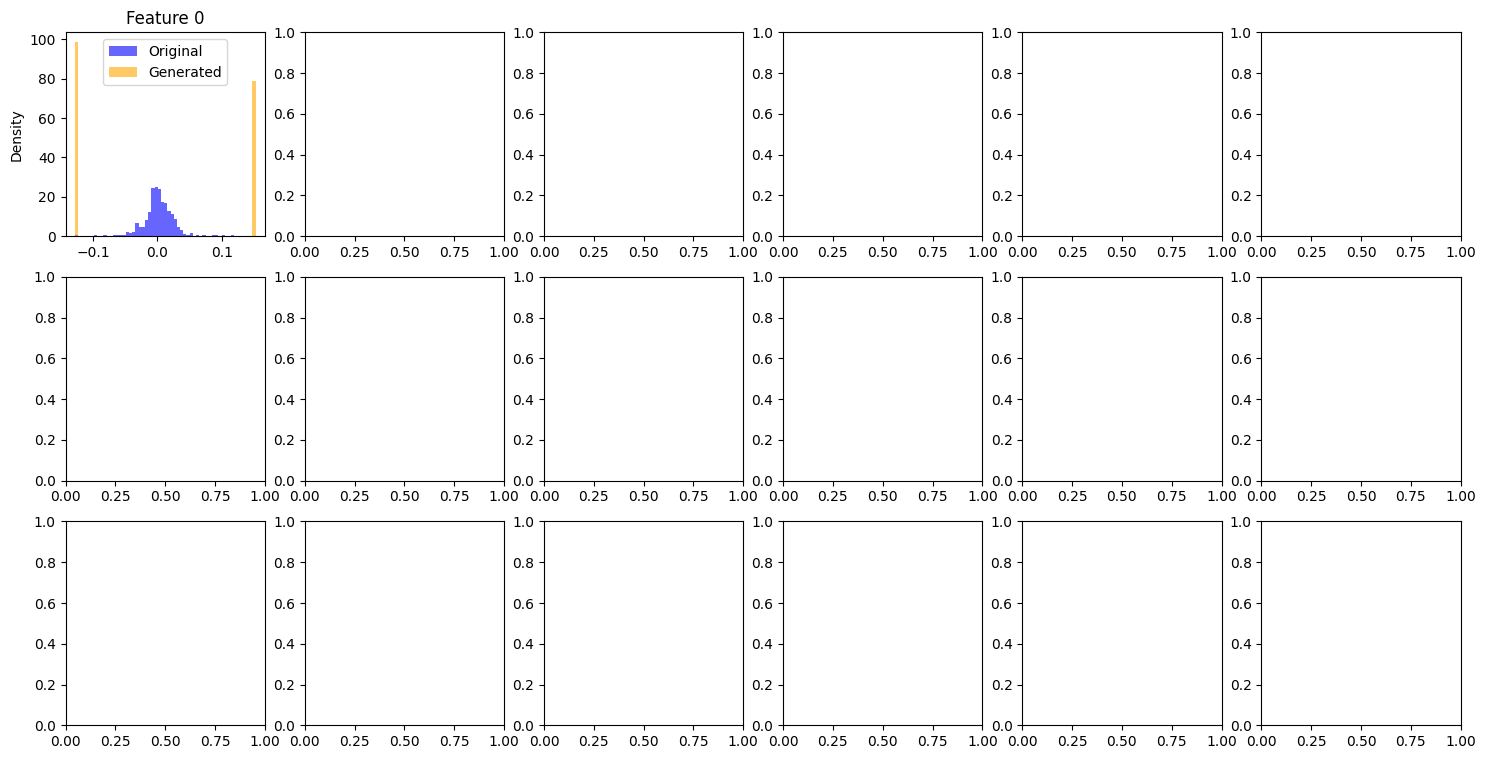

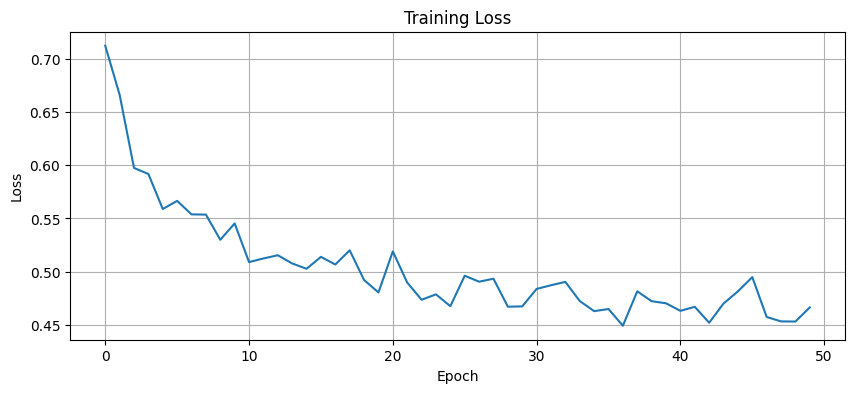


Generating samples...


Generating samples: 1000it [00:09, 108.54it/s]


ValueError: x and y must be the same size

In [32]:
"""
Improved Tabular Diffusion Model
Fixes generation quality issues with better architecture and sampling
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, QuantileTransformer
import pandas as pd
from typing import Optional, Union, List
import logging
import warnings
warnings.filterwarnings('ignore')

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


# ==================== Improved Model Architecture ====================

class TimestepEmbedding(nn.Module):
    """Improved timestep embedding with learnable components"""
    def __init__(self, dim, max_period=10000):
        super().__init__()
        self.dim = dim
        self.max_period = max_period
        
        # Learnable linear transformation after sinusoidal encoding
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.SiLU(),
            nn.Linear(dim * 4, dim),
            nn.SiLU()
        )
    
    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        freqs = torch.exp(
            -np.log(self.max_period) * torch.arange(half_dim, dtype=torch.float32, device=device) / half_dim
        )
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if self.dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        
        return self.mlp(embedding)


class ResidualMLPBlock(nn.Module):
    """Improved residual block with better normalization"""
    def __init__(self, dim, time_emb_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.linear1 = nn.Linear(dim, dim * 2)
        
        self.norm2 = nn.LayerNorm(dim * 2)
        self.linear2 = nn.Linear(dim * 2, dim)
        
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim * 2)
        )
        
        self.dropout = nn.Dropout(dropout)
        self.act = nn.SiLU()
    
    def forward(self, x, t):
        h = self.norm1(x)
        h = self.linear1(h)
        
        # Add time embedding
        t_emb = self.time_mlp(t)
        h = h + t_emb
        
        h = self.act(h)
        h = self.norm2(h)
        h = self.dropout(h)
        h = self.linear2(h)
        h = self.dropout(h)
        
        return x + h


class ImprovedTabularDiffusion(nn.Module):
    """Improved architecture with skip connections and better normalization"""
    def __init__(
        self,
        input_dim,
        hidden_dim=256,
        num_blocks=6,
        time_emb_dim=128,
        dropout=0.1
    ):
        super().__init__()
        self.input_dim = input_dim
        
        # Time embedding
        self.time_embed = TimestepEmbedding(time_emb_dim)
        
        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        )
        
        # Residual blocks
        self.blocks = nn.ModuleList([
            ResidualMLPBlock(hidden_dim, time_emb_dim, dropout)
            for _ in range(num_blocks)
        ])
        
        # Output projection with skip connection from input
        self.output_norm = nn.LayerNorm(hidden_dim)
        self.output_proj = nn.Linear(hidden_dim, input_dim)
        
        # Skip connection for input
        self.input_skip = nn.Linear(input_dim, input_dim)
        
        # Initialize output layer with small weights
        nn.init.zeros_(self.output_proj.weight)
        nn.init.zeros_(self.output_proj.bias)
    
    def forward(self, x, t):
        # Save input for skip connection
        x_skip = self.input_skip(x)
        
        # Time embedding
        t_emb = self.time_embed(t)
        
        # Process through network
        h = self.input_proj(x)
        
        for block in self.blocks:
            h = block(h, t_emb)
        
        h = self.output_norm(h)
        h = self.output_proj(h)
        
        # Add skip connection (helps preserve input structure)
        return h + x_skip * 0.1


# ==================== Improved Diffusion Process ====================

class ImprovedDiffusion:
    """Improved diffusion with variance preservation and better scheduling"""
    def __init__(
        self,
        noise_steps=1000,
        beta_start=0.0001,
        beta_end=0.02,
        device="cuda"
    ):
        self.noise_steps = noise_steps
        self.device = device
        
        # Use cosine schedule by default - better for tabular data
        self.betas = self.cosine_beta_schedule(noise_steps).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        
        # Calculations for diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        
        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        )
        self.posterior_log_variance_clipped = torch.log(
            torch.clamp(self.posterior_variance, min=1e-20)
        )
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)
        )
    
    def cosine_beta_schedule(self, timesteps, s=0.008):
        """Cosine schedule as proposed in https://arxiv.org/abs/2102.09672"""
        steps = timesteps + 1
        x = torch.linspace(0, timesteps, steps)
        alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)
    
    def q_sample(self, x_start, t, noise=None):
        """Forward diffusion process"""
        if noise is None:
            noise = torch.randn_like(x_start)
        
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t][:, None]
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t][:, None]
        
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise, noise
    
    def p_mean_variance(self, model, x, t):
        """Calculate mean and variance for reverse process"""
        # Predict noise
        pred_noise = model(x, t)
        
        # Get coefficients
        betas_t = self.betas[t][:, None]
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t][:, None]
        sqrt_recip_alphas_t = 1.0 / torch.sqrt(self.alphas[t])[:, None]
        
        # Calculate mean
        model_mean = sqrt_recip_alphas_t * (
            x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t
        )
        
        # Calculate variance
        posterior_variance_t = self.posterior_variance[t][:, None]
        posterior_log_variance_t = self.posterior_log_variance_clipped[t][:, None]
        
        return model_mean, posterior_variance_t, posterior_log_variance_t
    
    @torch.no_grad()
    def p_sample(self, model, x, t):
        """Single reverse diffusion step"""
        model_mean, _, model_log_variance = self.p_mean_variance(model, x, t)
        noise = torch.randn_like(x)
        
        # No noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x.shape) - 1))))
        
        return model_mean + nonzero_mask * torch.exp(0.5 * model_log_variance) * noise
    
    @torch.no_grad()
    def sample(self, model, n_samples, dim, progress=True):
        """Generate samples using reverse diffusion"""
        model.eval()
        
        # Start from pure noise
        x = torch.randn(n_samples, dim).to(self.device)
        
        timesteps = reversed(range(self.noise_steps))
        if progress:
            timesteps = tqdm(timesteps, desc="Generating samples")
        
        for t in timesteps:
            t_batch = torch.full((n_samples,), t, device=self.device, dtype=torch.long)
            x = self.p_sample(model, x, t_batch)
        
        model.train()
        return x


# ==================== Improved Dataset ====================

class TabularDataset(Dataset):
    """Dataset with better normalization for diffusion"""
    def __init__(
        self, 
        data: Union[pd.DataFrame, np.ndarray, torch.Tensor],
        normalize_method: str = "quantile"
    ):
        """
        Args:
            data: Input data
            normalize_method: 'standard', 'quantile', or 'minmax'
        """
        # Convert to numpy
        if isinstance(data, pd.DataFrame):
            self.columns = data.columns.tolist()
            data = data.values
        elif isinstance(data, torch.Tensor):
            data = data.numpy()
        else:
            self.columns = None
        
        # Handle NaN
        col_mean = np.nanmean(data, axis=0)
        inds = np.where(np.isnan(data))
        data[inds] = np.take(col_mean, inds[1])
        
        # Normalize data
        if normalize_method == "quantile":
            # Quantile transformation maps to uniform then to normal
            self.scaler = QuantileTransformer(
                output_distribution='normal',
                n_quantiles=min(1000, len(data))
            )
        elif normalize_method == "standard":
            self.scaler = StandardScaler()
        else:
            from sklearn.preprocessing import MinMaxScaler
            self.scaler = MinMaxScaler(feature_range=(-1, 1))
        
        self.data = self.scaler.fit_transform(data).astype(np.float32)
        
        # Clip extreme values
        self.data = np.clip(self.data, -5, 5)
        
        logging.info(f"Dataset shape: {self.data.shape}")
        logging.info(f"Data range: [{self.data.min():.3f}, {self.data.max():.3f}]")
        logging.info(f"Data mean: {self.data.mean():.3f}, std: {self.data.std():.3f}")
    
    def inverse_transform(self, data):
        """Convert back to original scale"""
        if isinstance(data, torch.Tensor):
            data = data.cpu().numpy()
        return self.scaler.inverse_transform(data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)


# ==================== Training with Better Loss ====================

def train_diffusion(
    model,
    diffusion,
    train_loader,
    epochs=100,
    lr=1e-3,
    device="cuda"
):
    """Train with improved loss calculation"""
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_losses = []
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for batch in pbar:
            batch = batch.to(device)
            batch_size = batch.shape[0]
            
            # Sample random timesteps
            t = torch.randint(0, diffusion.noise_steps, (batch_size,), device=device)
            
            # Add noise using improved forward process
            noisy_data, noise = diffusion.q_sample(batch, t)
            
            # Predict noise
            predicted_noise = model(noisy_data, t)
            
            # Simple MSE loss
            loss = F.mse_loss(predicted_noise, noise)
            
            # Backprop
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            
            epoch_losses.append(loss.item())
            pbar.set_postfix(loss=loss.item())
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        scheduler.step()
        
        if (epoch + 1) % 10 == 0:
            logging.info(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")
    
    return losses


# ==================== Visualization ====================

def visualize_results(original_data, generated_data, n_features=6):
    """Better visualization with marginal distributions"""
    n_show = min(n_features, original_data.shape[1])
    
    fig, axes = plt.subplots(3, n_show, figsize=(n_show*3, 9))
    
    for i in range(n_show):
        # Histogram
        axes[0, i].hist(original_data[:, i], bins=50, alpha=0.6, density=True, label='Original', color='blue')
        axes[0, i].hist(generated_data[:, i], bins=50, alpha=0.6, density=True, label='Generated', color='orange')
        axes[0, i].set_title(f'Feature {i}')
        axes[0, i].legend()
        axes[0, i].set_ylabel('Density')
        
        # Q-Q plot
        from scipy import stats
        osm, osr = stats.probplot(original_data[:, i], plot=None)
        gsm, gsr = stats.probplot(generated_data[:, i], plot=None)
        axes[1, i].scatter(osm, osr, alpha=0.6, label='Original', s=10)
        axes[1, i].scatter(gsm, gsr, alpha=0.6, label='Generated', s=10)
        axes[1, i].plot([-3, 3], [-3, 3], 'r--', alpha=0.5)
        axes[1, i].set_title(f'Q-Q Plot Feature {i}')
        axes[1, i].set_xlabel('Theoretical Quantiles')
        axes[1, i].set_ylabel('Sample Quantiles')
        axes[1, i].legend()
        
        # Box plot
        axes[2, i].boxplot([original_data[:, i], generated_data[:, i]], labels=['Original', 'Generated'])
        axes[2, i].set_title(f'Box Plot Feature {i}')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n=== Generation Quality ===")
    print(f"Original  - Mean: {original_data.mean():.4f}, Std: {original_data.std():.4f}")
    print(f"Generated - Mean: {generated_data.mean():.4f}, Std: {generated_data.std():.4f}")
    
    # Correlation preservation
    orig_corr = np.corrcoef(original_data.T)
    gen_corr = np.corrcoef(generated_data.T)
    corr_diff = np.abs(orig_corr - gen_corr).mean()
    print(f"Mean correlation difference: {corr_diff:.4f}")


# ==================== Main Function ====================

def main():
    """Example usage"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Generate synthetic data for testing
    np.random.seed(42)
    n_samples = 1000
    n_features = 10
    # n_samples, n_features = data.shape
    # # Create more complex synthetic data
    data = np.random.randn(n_samples, n_features)
    # Add some correlation structure
    for i in range(1, n_features):
        data[:, i] = 0.5 * data[:, i-1] + 0.5 * np.random.randn(n_samples)
    
    # Create dataset with quantile normalization
    dataset = TabularDataset(data, normalize_method="quantile")
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Initialize improved model
    model = ImprovedTabularDiffusion(
        input_dim=n_features,
        hidden_dim=256,
        num_blocks=6,
        time_emb_dim=128,
        dropout=0.1
    ).to(device)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Initialize diffusion with better schedule
    diffusion = ImprovedDiffusion(
        noise_steps=1000,
        device=device
    )
    
    # Train
    print("\nTraining...")
    losses = train_diffusion(
        model=model,
        diffusion=diffusion,
        train_loader=train_loader,
        epochs=50,
        lr=1e-3,
        device=device
    )
    
    # Plot loss
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.show()
    
    # Generate samples
    print("\nGenerating samples...")
    n_gen = 500
    generated = diffusion.sample(model, n_gen, n_features)
    
    # Convert back to original scale
    generated_original = dataset.inverse_transform(generated.cpu().numpy())
    original_data = dataset.inverse_transform(dataset.data[:n_gen])
    
    # Visualize
    visualize_results(original_data, generated_original)
    
    return model, diffusion, dataset


# ==================== Easy Interface for Your Data ====================

def train_on_financial_data(
    data: Union[pd.DataFrame, np.ndarray],
    epochs: int = 100,
    batch_size: int = 32,
    device: str = "auto"
):
    """
    Simplified interface for financial data
    
    Example:
        # Your exact code
        data = equity_data.pivot_table(
            index='tradedate', 
            columns='Ticker',
            values='prior_1D_return'
        ).fillna(0)
        
        model, diffusion, dataset = train_on_financial_data(data.values)
    """
    if device == "auto":
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Create dataset with quantile transformation (best for financial returns)
    dataset = TabularDataset(data, normalize_method="quantile")
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    input_dim = dataset.data.shape[1]
    
    # Create model
    model = ImprovedTabularDiffusion(
        input_dim=input_dim,
        hidden_dim=256,
        num_blocks=8,  # More blocks for complex data
        time_emb_dim=128,
        dropout=0.1
    ).to(device)
    
    # Create diffusion
    diffusion = ImprovedDiffusion(noise_steps=1000, device=device)
    
    # Train
    print(f"Training on {data.shape} data...")
    losses = train_diffusion(model, diffusion, train_loader, epochs, lr=1e-3, device=device)
    
    # Generate test samples
    print("\nGenerating test samples...")
    test_samples = diffusion.sample(model, 100, input_dim, progress=False)
    test_original = dataset.inverse_transform(test_samples.cpu().numpy())
    
    # Quick quality check
    original_subset = dataset.inverse_transform(dataset.data[:100])
    print(f"\nOriginal stats  - Mean: {original_subset.mean():.4f}, Std: {original_subset.std():.4f}")
    print(f"Generated stats - Mean: {test_original.mean():.4f}, Std: {test_original.std():.4f}")
    
    return model, diffusion, dataset


if __name__ == "__main__":
    main()

In [57]:
"""
Simple Vanilla DDPM for Tabular Data - Spiral Example
Minimal implementation focusing on core DDPM concepts
"""

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ==================== Data Generation ====================

def generate_spiral_data(n_samples=2000, noise=0.1):
    """Generate 2D spiral dataset"""
    t = np.linspace(0, 4*np.pi, n_samples)
    x = t * np.cos(t) + noise * np.random.randn(n_samples)
    y = t * np.sin(t) + noise * np.random.randn(n_samples)
    
    # Normalize to [-1, 1]
    data = np.column_stack([x, y])
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return data.astype(np.float32)

# ==================== Simple Neural Network ====================

class SimpleNet(nn.Module):
    """Simple MLP for denoising"""
    def __init__(self, input_dim=2, hidden_dim=128, time_dim=32):
        super().__init__()
        
        # Time embedding (simplified)
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_dim),
            nn.ReLU(),
            nn.Linear(time_dim, time_dim)
        )
        
        # Main network
        self.net = nn.Sequential(
            nn.Linear(input_dim + time_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x, t):
        # Simple time encoding
        t_normalized = t.float().unsqueeze(-1) / 1000.0  # Normalize timestep
        t_emb = self.time_embed(t_normalized)
        
        # Concatenate input and time embedding
        x_with_time = torch.cat([x, t_emb], dim=-1)
        return self.net(x_with_time)

# ==================== DDPM Implementation ====================

class SimpleDDPM:
    def __init__(self, timesteps=4000, beta_start=1e-4, beta_end=0.02):
        self.timesteps = timesteps
        
        # Linear noise schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        
        # For sampling
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alpha_cumprod)
    
    def add_noise(self, x_0, t):
        """Forward diffusion: add noise to data"""
        noise = torch.randn_like(x_0)
        
        sqrt_alpha_cumprod_t = self.sqrt_alpha_cumprod[t].unsqueeze(-1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alpha_cumprod[t].unsqueeze(-1)
        
        # x_t = sqrt(alpha_cumprod_t) * x_0 + sqrt(1 - alpha_cumprod_t) * noise
        x_t = sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise
        return x_t, noise
    
    def sample(self, model, n_samples, input_dim=32):
        """Reverse diffusion: generate samples"""
        model.eval()
        
        # Start from pure noise
        x = torch.randn(n_samples, input_dim).to(device)
        
        with torch.no_grad():
            for t in tqdm(reversed(range(self.timesteps)), desc="Sampling"):
                # Current timestep for all samples
                t_tensor = torch.full((n_samples,), t, dtype=torch.long).to(device)
                
                # Predict noise
                predicted_noise = model(x, t_tensor)
                
                # Compute coefficients
                alpha_t = self.alphas[t]
                alpha_cumprod_t = self.alpha_cumprod[t]
                beta_t = self.betas[t]
                
                # Compute mean of reverse distribution
                x_mean = (1.0 / torch.sqrt(alpha_t)) * (
                    x - (beta_t / torch.sqrt(1.0 - alpha_cumprod_t)) * predicted_noise
                )
                
                if t > 0:
                    # Add noise (except for last step)
                    noise = torch.randn_like(x)
                    x = x_mean + torch.sqrt(beta_t) * noise
                else:
                    x = x_mean
        
        model.train()
        return x

# ==================== Training ====================

def train_ddpm(model, data, ddpm, epochs=10000, batch_size=128, lr=1e-3):
    """Train the DDPM model"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    # Convert data to tensor
    data_tensor = torch.from_numpy(data).to(device)
    n_samples = len(data_tensor)
    
    losses = []
    
    for epoch in range(epochs):
        epoch_losses = []
        
        # Mini-batch training
        for i in range(0, n_samples, batch_size):
            batch = data_tensor[i:i+batch_size]
            
            # Sample random timesteps
            t = torch.randint(0, ddpm.timesteps, (len(batch),)).to(device)
            
            # Add noise
            x_t, noise = ddmp.add_noise(batch, t)
            
            # Predict noise
            predicted_noise = model(x_t, t)
            
            # Compute loss (simple MSE)
            loss = nn.MSELoss()(predicted_noise, noise)
            
            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    return losses

# ==================== Visualization ====================

def plot_results(original_data, generated_data, title="Results"):
    """Plot original vs generated data"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original data
    ax1.scatter(original_data[:, 0], original_data[:, 1], alpha=0.6, s=20)
    ax1.set_title("Original Spiral Data")
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    
    # Generated data
    ax2.scatter(generated_data[:, 0], generated_data[:, 1], alpha=0.6, s=20, color='red')
    ax2.set_title("Generated Data")
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ==================== Main Execution ====================


Using device: cpu


In [58]:
type(spiral_data)

numpy.ndarray

In [59]:
spiral_data.shape

(1365, 32)

Generating spiral data...
Model has 157568 parameters

Training DDPM...
Epoch 100/10000, Loss: 0.0307
Epoch 200/10000, Loss: 0.0184
Epoch 300/10000, Loss: 0.0140
Epoch 400/10000, Loss: 0.0137
Epoch 500/10000, Loss: 0.0105
Epoch 600/10000, Loss: 0.0115
Epoch 700/10000, Loss: 0.0089
Epoch 800/10000, Loss: 0.0095
Epoch 900/10000, Loss: 0.0103
Epoch 1000/10000, Loss: 0.0112
Epoch 1100/10000, Loss: 0.0092
Epoch 1200/10000, Loss: 0.0090
Epoch 1300/10000, Loss: 0.0083
Epoch 1400/10000, Loss: 0.0068
Epoch 1500/10000, Loss: 0.0077
Epoch 1600/10000, Loss: 0.0079
Epoch 1700/10000, Loss: 0.0073
Epoch 1800/10000, Loss: 0.0064
Epoch 1900/10000, Loss: 0.0085
Epoch 2000/10000, Loss: 0.0078
Epoch 2100/10000, Loss: 0.0068
Epoch 2200/10000, Loss: 0.0066
Epoch 2300/10000, Loss: 0.0070
Epoch 2400/10000, Loss: 0.0073
Epoch 2500/10000, Loss: 0.0065
Epoch 2600/10000, Loss: 0.0073
Epoch 2700/10000, Loss: 0.0065
Epoch 2800/10000, Loss: 0.0078
Epoch 2900/10000, Loss: 0.0069
Epoch 3000/10000, Loss: 0.0084
Epoch 3

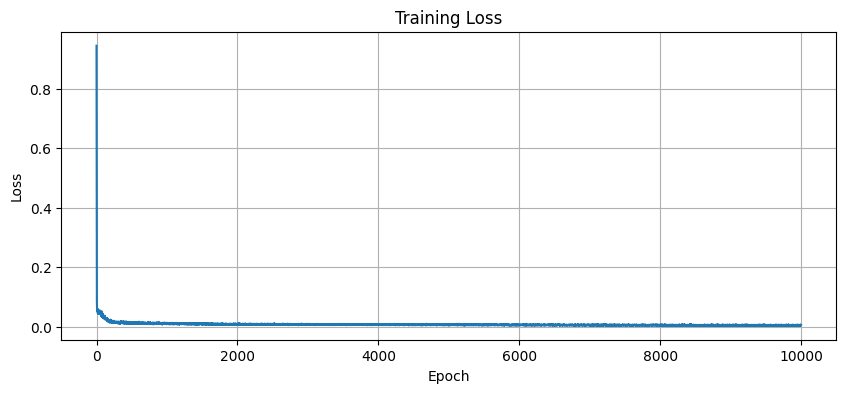

In [67]:

# Generate spiral data
print("Generating spiral data...")
spiral_data = data.astype(np.float32) #generate_spiral_data(n_samples=2000)

# Initialize model and DDPM
model = SimpleNet(input_dim=32, hidden_dim=256, time_dim=32).to(device)
ddmp = SimpleDDPM(timesteps=5000)

print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

# Train model
print("\nTraining DDPM...")
losses = train_ddpm(
    model=model,
    data=spiral_data,
    ddpm=ddmp,
    epochs=10000,
    batch_size=128,
    lr=1e-3
)

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()




Generating samples...


Sampling: 5000it [00:43, 114.05it/s]


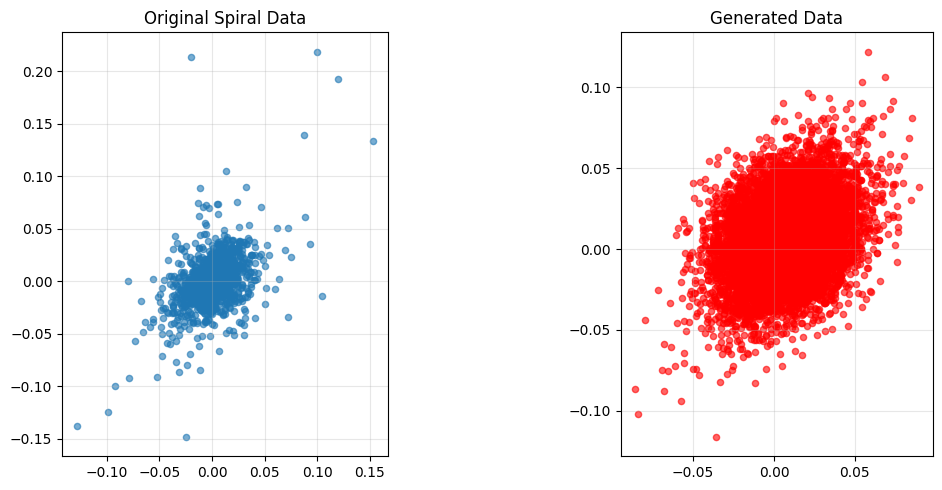


=== Statistics ===
Original - Mean: 0.001, Std: 0.022
Generated - Mean: 0.001, Std: 0.023

Done! The model has learned to generate spiral-like data points.


In [78]:
# Generate samples
print("\nGenerating samples...")
n_generate = 10000
generated_samples = ddmp.sample(model, n_generate).cpu().numpy()

# Visualize results
plot_results(spiral_data[:n_generate], generated_samples)

# Print statistics
print("\n=== Statistics ===")
print(f"Original - Mean: {spiral_data.mean():.3f}, Std: {spiral_data.std():.3f}")
print(f"Generated - Mean: {generated_samples.mean():.3f}, Std: {generated_samples.std():.3f}")

print("\nDone! The model has learned to generate spiral-like data points.")

In [79]:
from research.plots import qqplot, qqplot_against_normal

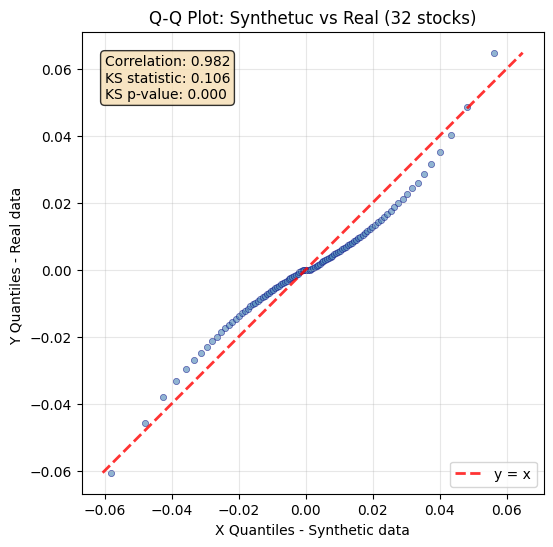

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Flatten the arrays (concatenate all columns)
synthetic_flat = generated_samples.flatten()
real_flat = data.flatten()

_=qqplot(x=synthetic_flat , 
         y=real_flat,
        title  = 'Q-Q Plot: Synthetuc vs Real (32 stocks)',
    xlabel  = 'X Quantiles - Synthetic data',
    ylabel  = 'Y Quantiles - Real data ',)
plt.show()
plt.close()

In [85]:
np.linalg.cond(pd.DataFrame(generated_samples).cov())

37.28701827777002

In [86]:
np.linalg.cond(pd.DataFrame(data).cov())

113.73615526195036